In [1]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats("svg")
import shap

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')
shap.initjs()

In [2]:
# Load the data

df=pd.read_excel("./Data Scientist - Recruitment task - Raw data.xlsx",
                         sheet_name="Raw Data")
df.Day=pd.to_datetime(df.Day)
foot_print=df.copy()
foot_print.head()

,Day,Advertising_Spend,Number_of_Visitors,Average_Session_Duration,Page_Load_Time,Day_of_Week,Impressions
0,2021-10-01,28008.521469,19925,3.54,4.91,Friday,140811
1,2021-10-02,20812.773757,33385,1.40,3.00,Saturday,82038
2,2021-10-03,22878.770076,38600,1.33,1.35,Sunday,36693
3,2021-10-04,11876.136172,19424,3.48,3.12,Monday,76526
4,2021-10-05,33387.536319,21196,3.48,1.42,Tuesday,124470


## Quick exploration of the data

In [3]:
# Quick glance the data attributes

foot_print.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Day                       1045 non-null   datetime64[ns]
 1   Advertising_Spend         1045 non-null   float64       
 2   Number_of_Visitors        1045 non-null   int64         
 3   Average_Session_Duration  1045 non-null   float64       
 4   Page_Load_Time            1045 non-null   float64       
 5   Day_of_Week               1045 non-null   object        
 6   Impressions               1045 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 57.3+ KB


In [4]:
foot_print.shape

(1045, 7)

In [5]:
foot_print.isna().sum()

Day                         0
Advertising_Spend           0
Number_of_Visitors          0
Average_Session_Duration    0
Page_Load_Time              0
Day_of_Week                 0
Impressions                 0
dtype: int64

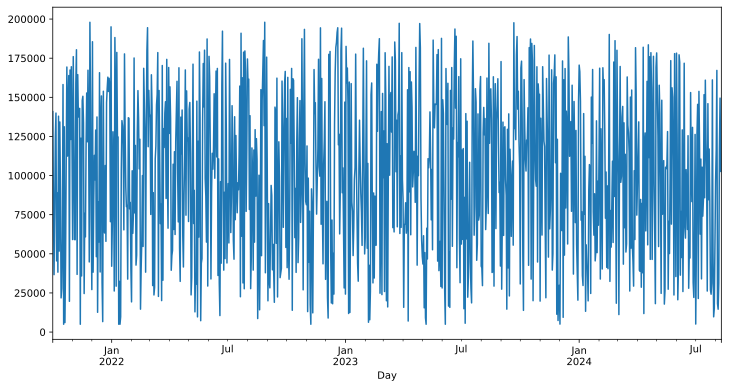

In [6]:
# Plot the Impression over time to quickly identify any trend and/or seasonality

foot_print.index=foot_print.Day
foot_print.drop(columns=['Day'],
                axis=1,
                inplace=True)
plt.figure(figsize=(12,6))
foot_print.Impressions.plot.line();

## Feature engineering

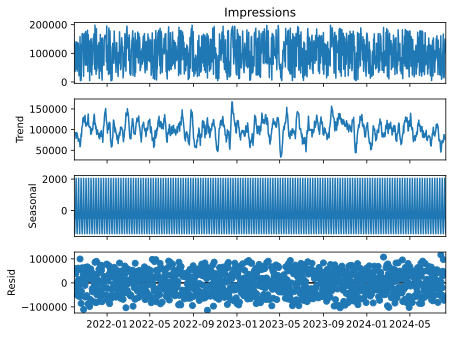

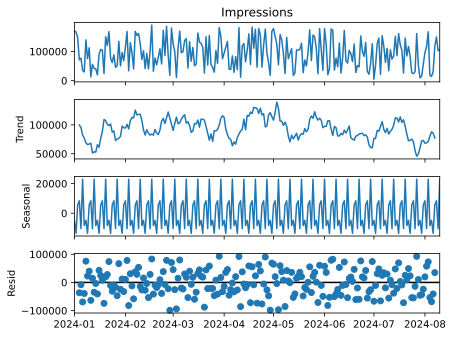

In [7]:
# Visually examining the trend and seasonality on the entire and a sample of the data

foot_print_fe=foot_print.copy()
day_of_week_dummy=pd.get_dummies(foot_print_fe.Day_of_Week).astype('int64')
foot_print_fe=foot_print.copy().drop(columns=['Day_of_Week'],
                                         axis=1)

foot_print_fe=pd.concat([foot_print_fe,day_of_week_dummy],axis=1)
seasonal_decompose_components=seasonal_decompose(foot_print_fe.Impressions,model='additive',period=7)
seasonal_decompose_components.plot()
seasonal_decompose(foot_print_fe[foot_print_fe.index>=pd.to_datetime('2024-01-01')].Impressions,model='additive').plot();

In [8]:
# Create trend, lagged and rolling average features on target as well as exogenous variables

foot_print_fe['Trend']=seasonal_decompose(foot_print_fe.Impressions.shift(1).dropna(),model='additive',period=7).trend
foot_print_fe['Impressions_lag7']=foot_print_fe.Impressions.shift(7)
foot_print_fe['Advertising_Spend_lag7']=foot_print_fe.Advertising_Spend.shift(7)
foot_print_fe['Num_vistitors_lag7']=foot_print_fe.Number_of_Visitors.shift(7)
foot_print_fe['Average_Session_Duration_lag7']=foot_print_fe.Average_Session_Duration.shift(7)
foot_print_fe['Page_Load_Time_lag7']=foot_print_fe.Page_Load_Time.shift(7)
foot_print_fe['Impressions_7_day_avg']=foot_print_fe.Impressions.shift(1).rolling(window=7).mean()
foot_print_fe['Advertising_Spend_7_day_avg']=foot_print_fe.Advertising_Spend.shift(1).rolling(window=7).mean()
foot_print_fe['Num_vistitor_7_day_avg']=foot_print_fe.Number_of_Visitors.shift(1).rolling(window=7).mean()
foot_print_fe['Average_Session_Duration_7_day_avg']=foot_print_fe.Average_Session_Duration.shift(1).rolling(window=7).mean()
foot_print_fe['Page_Load_Time_7_day_avg']=foot_print_fe.Page_Load_Time.shift(1).rolling(window=7).mean()
foot_print_fe.dropna(axis=0,inplace=True)
features_droped=['Number_of_Visitors','Average_Session_Duration','Page_Load_Time','Monday']
foot_print_fe.drop(columns=features_droped,axis=1,inplace=True)
foot_print_fe.shape

(1035, 19)

### A few comments on the feature engineering
* The features created here are not comprehensive.
* More experiments are necessary to create more powerful features to make the forecasting even precise.
* For example, as this is a daily data, I assumed a weekly seasonality which could be decided through more analyses such as auto correlation analysis to figure out how many lags and rolling average windows would be appropriate.
* As I assumed only weekly seasonality, I only included lag 7 of the impression as well as other exogenous features as features. Ideally, all lags from 1 to 7 should be considered.
* Similar is the case for rolling averages where I only considered window size 7 while all window sizes starting from 2 to 7 should be included.

## Model building

In [9]:
# Prepate training and test samples

train_df=foot_print_fe[foot_print_fe.index<pd.to_datetime('2024-01-01')]
test_df=foot_print_fe[foot_print_fe.index>=pd.to_datetime('2024-01-01')]
X_train,X_test,Y_train,Y_test=train_df.drop(columns='Impressions'),test_df.drop(columns='Impressions'),train_df.Impressions,test_df.Impressions

Train MAE: 15056.35953374233
Test MAE: 38981.744318181816
Train and test diff: 23925.384784439484


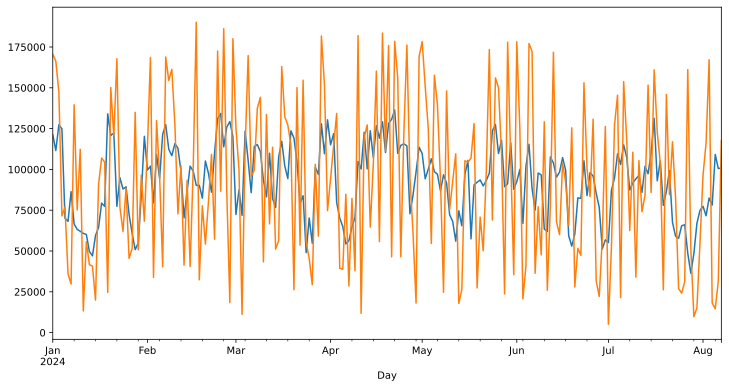

In [10]:
# Fit and assess random forest regression model

plt.figure(figsize=(12,6))
model_2=RandomForestRegressor()
model_2.fit(X_train,Y_train)

mae_2_train=mean_absolute_error(y_true=Y_train,y_pred=model_2.predict(X_train))
mae_2_test=mean_absolute_error(y_true=Y_test,y_pred=model_2.predict(X_test))
print(f'Train MAE: {mae_2_train}')
print(f'Test MAE: {mae_2_test}')
print(f'Train and test diff: {abs(mae_2_test-mae_2_train)}')
test_df['Forecasted']=model_2.predict(X_test)
test_df.Forecasted.plot.line()
test_df.Impressions.plot.line();

Train MAE: 28173.50526357075
Test MAE: 38750.380434713734
Train and test diff: 10576.875171142983


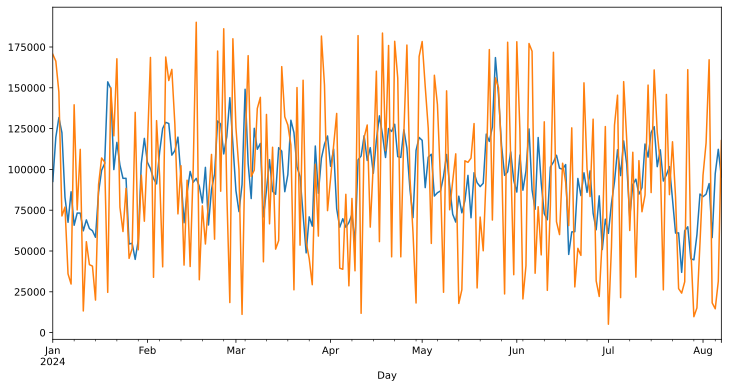

In [11]:
# Fit and assess gradient boosting regression model

plt.figure(figsize=(12,6))
model_3=GradientBoostingRegressor()
model_3.fit(X_train,Y_train)

mae_2_train=mean_absolute_error(y_true=Y_train,y_pred=model_3.predict(X_train))
mae_2_test=mean_absolute_error(y_true=Y_test,y_pred=model_3.predict(X_test))
print(f'Train MAE: {mae_2_train}')
print(f'Test MAE: {mae_2_test}')
print(f'Train and test diff: {abs(mae_2_test-mae_2_train)}')
test_df['Forecasted']=model_3.predict(X_test)
test_df.Forecasted.plot.line()
test_df.Impressions.plot.line();

## Feature selection

In [12]:
# Examining feature importance to identify redundant features

feature_importances=pd.DataFrame(data=model_3.feature_importances_,
             index=model_3.feature_names_in_).rename(columns={0:'Importance'}).sort_values(by='Importance', ascending=False)
feature_importances['Cum_Importance']=feature_importances.Importance.cumsum()
feature_importances

,Importance,Cum_Importance
Trend,0.412910,0.412910
Impressions_7_day_avg,0.196655,0.609564
Impressions_lag7,0.083687,0.693252
Average_Session_Duration_7_day_avg,0.056050,0.749302
Average_Session_Duration_lag7,0.044818,0.794120
Page_Load_Time_7_day_avg,0.037111,0.831231
Num_vistitors_lag7,0.036487,0.867718
Num_vistitor_7_day_avg,0.032654,0.900372
Advertising_Spend_lag7,0.031762,0.932134
Page_Load_Time_lag7,0.023531,0.955664


In [13]:
# Drop days of the week dummies as they do not contribute significantly to the prediction

features_to_drop=['Friday','Wednesday','Saturday','Thursday','Sunday','Tuesday']
foot_print_fe=foot_print_fe.drop(columns=features_to_drop,
                                 axis=1)

In [14]:
# Create train and test samples on the reduced feature dataset

train_df=foot_print_fe[foot_print_fe.index<pd.to_datetime('2024-01-01')]
test_df=foot_print_fe[foot_print_fe.index>=pd.to_datetime('2024-01-01')]
X_train,X_test,Y_train,Y_test=train_df.drop(columns='Impressions'),test_df.drop(columns='Impressions'),train_df.Impressions,test_df.Impressions

Train MAE: 28238.209815271824
Test MAE: 38640.95647842156
Train and test diff: 10402.746663149737


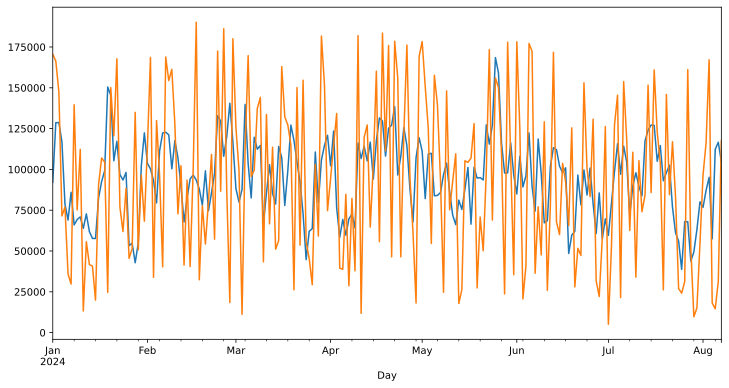

In [15]:
# Train and assess a gradient boosting model on reduced features

plt.figure(figsize=(12,6))
model_3=GradientBoostingRegressor()
model_3.fit(X_train,Y_train)

mae_2_train=mean_absolute_error(y_true=Y_train,y_pred=model_3.predict(X_train))
mae_2_test=mean_absolute_error(y_true=Y_test,y_pred=model_3.predict(X_test))
print(f'Train MAE: {mae_2_train}')
print(f'Test MAE: {mae_2_test}')
print(f'Train and test diff: {abs(mae_2_test-mae_2_train)}')
test_df['Forecasted']=model_3.predict(X_test)
test_df.Forecasted.plot.line()
test_df.Impressions.plot.line();

In [16]:
# Examin the feature importance on the reduced feature set

feature_importances=pd.DataFrame(data=model_3.feature_importances_,
             index=model_3.feature_names_in_).rename(columns={0:'Importance'}).sort_values(by='Importance', ascending=False)
feature_importances['Cum_Importance']=feature_importances.Importance.cumsum()
feature_importances

,Importance,Cum_Importance
Trend,0.413320,0.413320
Impressions_7_day_avg,0.195197,0.608518
Impressions_lag7,0.088399,0.696917
Average_Session_Duration_7_day_avg,0.053246,0.750163
Page_Load_Time_7_day_avg,0.042717,0.792880
Average_Session_Duration_lag7,0.042706,0.835585
Num_vistitor_7_day_avg,0.037750,0.873335
Advertising_Spend_lag7,0.034683,0.908019
Num_vistitors_lag7,0.034255,0.942273
Page_Load_Time_lag7,0.024479,0.966753


271

Train MAE: 28238.209815271828
Test MAE: 38347.89474745148
Train and test diff in MAE: 10109.68493217965


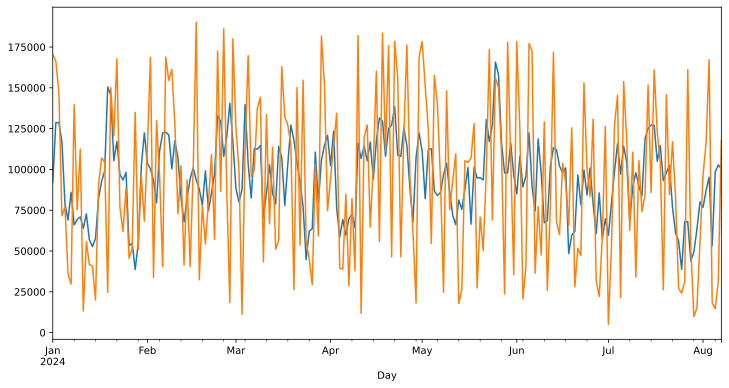

In [17]:
# Tune the random state model parameter to optimize overfit

randon_states={}
for i in range(1,1000):
    model_gb=GradientBoostingRegressor(random_state=i)
    model_gb.fit(X_train,Y_train)

    mae_train=mean_absolute_error(y_true=Y_train,y_pred=model_gb.predict(X_train))
    mae_test=mean_absolute_error(y_true=Y_test,y_pred=model_gb.predict(X_test))
    randon_states[i]=(abs(mae_test-mae_train))

best_random_state=min(randon_states.items(), key=lambda x: x[1])
display(best_random_state[0])

# Train and assess the tuned gradient boosting model

plt.figure(figsize=(12,6))
gbm_forecast=GradientBoostingRegressor(random_state=best_random_state[0])
gbm_forecast.fit(X_train,Y_train)

mae_train=mean_absolute_error(y_true=Y_train,y_pred=gbm_forecast.predict(X_train))
mae_test=mean_absolute_error(y_true=Y_test,y_pred=gbm_forecast.predict(X_test))
print(f'Train MAE: {mae_train}')
print(f'Test MAE: {mae_test}')
print(f'Train and test diff in MAE: {abs(mae_test-mae_train)}')
test_df['Forecasted']=gbm_forecast.predict(X_test)
test_df.Forecasted.plot.line()
test_df.Impressions.plot.line();

### A few comments on model selection
* The model has been selected on the basis of the comparatively lower difference between train MAE and test MAE than the random forest model indicating this overfits less than the random forest model. 
* The final model selected here is the Gradient Boosting model which only tuned for the random state hyperparameter. Hence, this model is still very naive.
* As the final model is still naive it's predictions are way off the ground reality in general. However, this model is still able to capture the general essence of the pattern.
* If I had more time to experiment, I would have tuned more hyper parameters of the model to make it less over fit.

## Interpreting the effects of the features on daily Impressions

In [18]:
# SHAP values on test data

model_explainer=shap.Explainer(gbm_forecast, foot_print_fe.drop(columns=['Impressions'],axis=1))
shap_values=model_explainer(X_test,check_additivity=False)

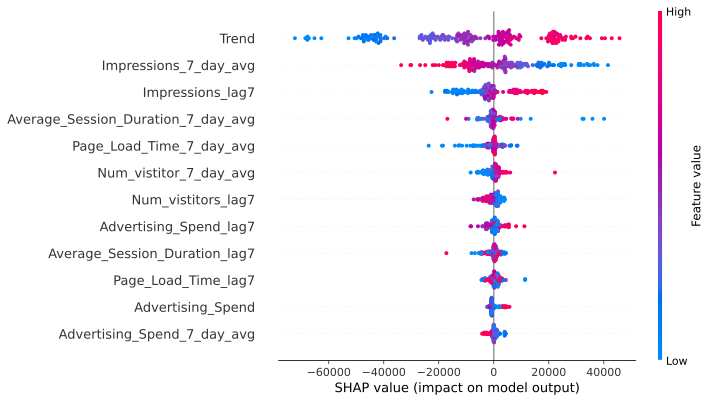

In [19]:
# Beeswarm plot

shap.plots.beeswarm(shap_values,max_display=20)

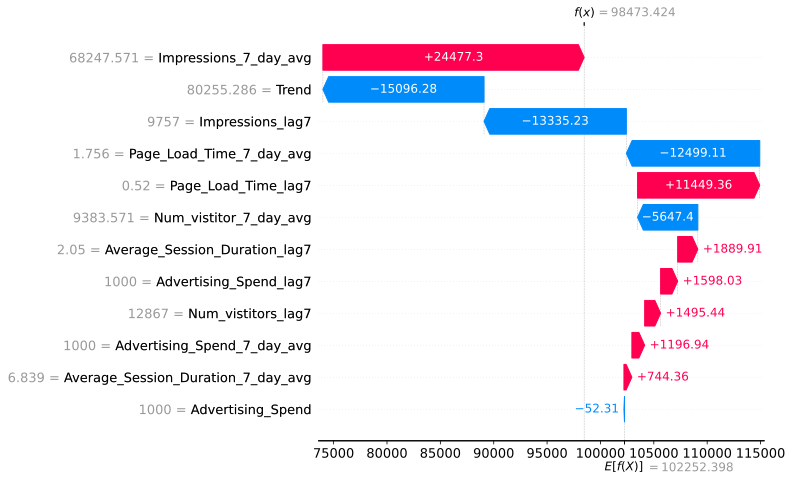

In [20]:
# Waterfall plot to explain effects of features on a single prediction

shap.plots.waterfall(shap_values[-3],max_display=20)

### Some interesting observations
* Interestingly, Past 7 days average impressions negatively influence the next day's forecasted footfalls meaning lower the average footfalls over the week greater impressions we can expect for the next day. Need more business understanding for this counter intuitive observation.
* Also, in general if the last week’s respective day's number of visitors are greater, we can expect lower impression on the next day. Also, needs greater understanding why this might be the case.
* With lower weekly average page load time we can expect lower impressions for the next day. Again, need greater understanding.
* Finally, with lower weekly average spend on advertising a greater number of impressions on the next day can be expected.

### Possible recommendations
* As far as my understanding goes the only actionable items are advertisement spend and page load time.
* Advertisement spends: Consider increasing the spend tomorrow to enhance the impression tomorrow as well as on the respective day next week.
* Page load time: Need greater understanding on this to make recommendations.

### Conclusion
#### In general, the results in its current state are not conclusive. We need further investigation and improvement of the model to make valuable actionable recommendations. Additionally, it is customary to carry out an analysis of advertisement spend elasticity to identify the inelastic spend region to minimize the spend and maximize the expected impressions.